# `OscaRobber`

# Part III: Text analysis

Now we are going to dig a little deeper into contents of movies to answer whether there is a correlation between keywords provided by IMDB and plots, and whether actors tend to act in movies of the same contents. The general idea is that actors play in movies that have related content. For this reason we would like to check whether movies in which an actor has played have more similar content (based on keywords provided by IMDB and keywords generated from plots) than based on other attributes. The way we'll answer those questions is to first represent each plot and each bunch of keywords as a vector using a bag-of-words approach, then we can calculate a similarity between pairs of movies in which actors have played using some vector-space difference. Afterwards we will perform a set of analysis steps to discover the connetivity between movies of similar contents. 

## Helpers

We will load a bunch of helper classes as usual. Apart from implementations `Table`, `MongoHelper` and `NetXHelper`, we define an additional class `TextHelper`, which contains helper methods for automating text analysis tasks. 

### Table

In [1]:
from lib.table import Table

### MongoDB helper

In [2]:
from lib.mongohelper import MongoHelper
mongo = MongoHelper('imdb')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'imdb')


### NetworkX helper

In [3]:
from lib.networkhelper import NetworkHelper
net = NetworkHelper()

### Feature helper

In [4]:
from lib.featurehelper import FeatureHelper
feat = FeatureHelper()

### Other libraries

In [5]:
from __future__ import division
import networkx as nx
import numpy as np
import random
import math
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pda
import nltk
nltk.data.path.append("/Users/olegpolakow/Documents/nltk_data")
from nltk.collocations import *

## Keywords

### Most common

In the first step of keywords analysis, we will examine keywords of movies of every genre rather than limit ourselves to one specific area of cinematography: what are the most common terms in the film industry? What are representing keywords of each genre? How contents of highest-grossing films differ from that of top-rated ones? To discover these interesting questions we load the entire keywords collection. We will only limit the number of genres we want to discover.

In [6]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [7]:
genres_filter = [0, 1, 5, 6, 7, 8, 10, 13, 18]
ids_filter = mongo.collect('genres', filter={'info': {'$in': genres_filter}}).keys()
# BSON document too large (41142824 bytes) - the connected serversupports BSON document sizes up to 16777216 bytes.
# Therefore we divide ids_filter into chunks of size 1000
keywords = {
    id: kwds 
    for chunk in chunks(ids_filter, 1000)
    for id, kwds in mongo.collect('keywords', filter={'id': {'$in': chunk}}, applymap='keywords_map').iteritems()
}

The best in keywords from IMDB is that they don't have to be tokenized or cleaned. IMDB did a great job here. First we will discover the most common terms among them and see which of them correlate with attributes like IMDB rating, gross and budget. We use `collections.Counter` (`nltk` would also do the job) to count them all in a very efficient manner. The best way to present the most frequent terms is to build a wordcloud. The method takes counters keyed by titles (the coolest thing here is that we allowed almost any number of wordclouds, so check this out!)

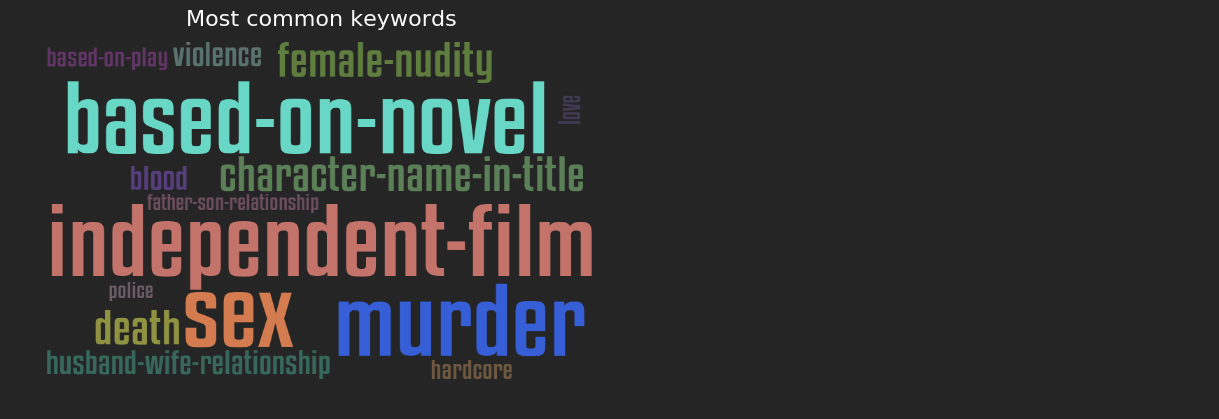

In [8]:
feat.wordclouds({
    'Most common keywords': Counter([token for tokens in keywords.values() for token in tokens]).most_common()
})

Those words are the most frequent terms in cinematography. On the top is word *independent-film*, a feature film that is produced mostly or completely outside of the major film studio system. We see there is a lot of independent films than we initially thought. But also films based on a novel enjoy the popularity. More general terms *murder*, *female-nudity*, *sex* and *death* describe what the most films are about: murders and sex. We are not suprised here though. Next great idea would be grouping keywords by genre to discover the difference (if any) between them, that's what the next couple of lines do. We will visualize them using nice wordclouds. 

In [9]:
def most_common_by_genre(tokens_dict, genres_filter):
    target_genres = {k: v for k, vs in mongo.collect('genres_map', filter={'id': {'$in': genres_filter}}).iteritems() for v in vs}
    ids_by_genre = defaultdict(list)
    for id, genres in mongo.collect('genres', filter={'info': {'$in': target_genres.keys()}}, applymap='genres_map').iteritems():
        for genre in genres:
            if genre in target_genres.values():
                ids_by_genre[genre].append(id)
    tokens_by_genre = defaultdict(list)
    for genre, ids in ids_by_genre.iteritems():
        for id in ids:
            if id in tokens_dict:
                tokens_by_genre[genre].extend(tokens_dict[id])
    return {genre: Counter(tokens).most_common() for genre, tokens in tokens_by_genre.iteritems()}

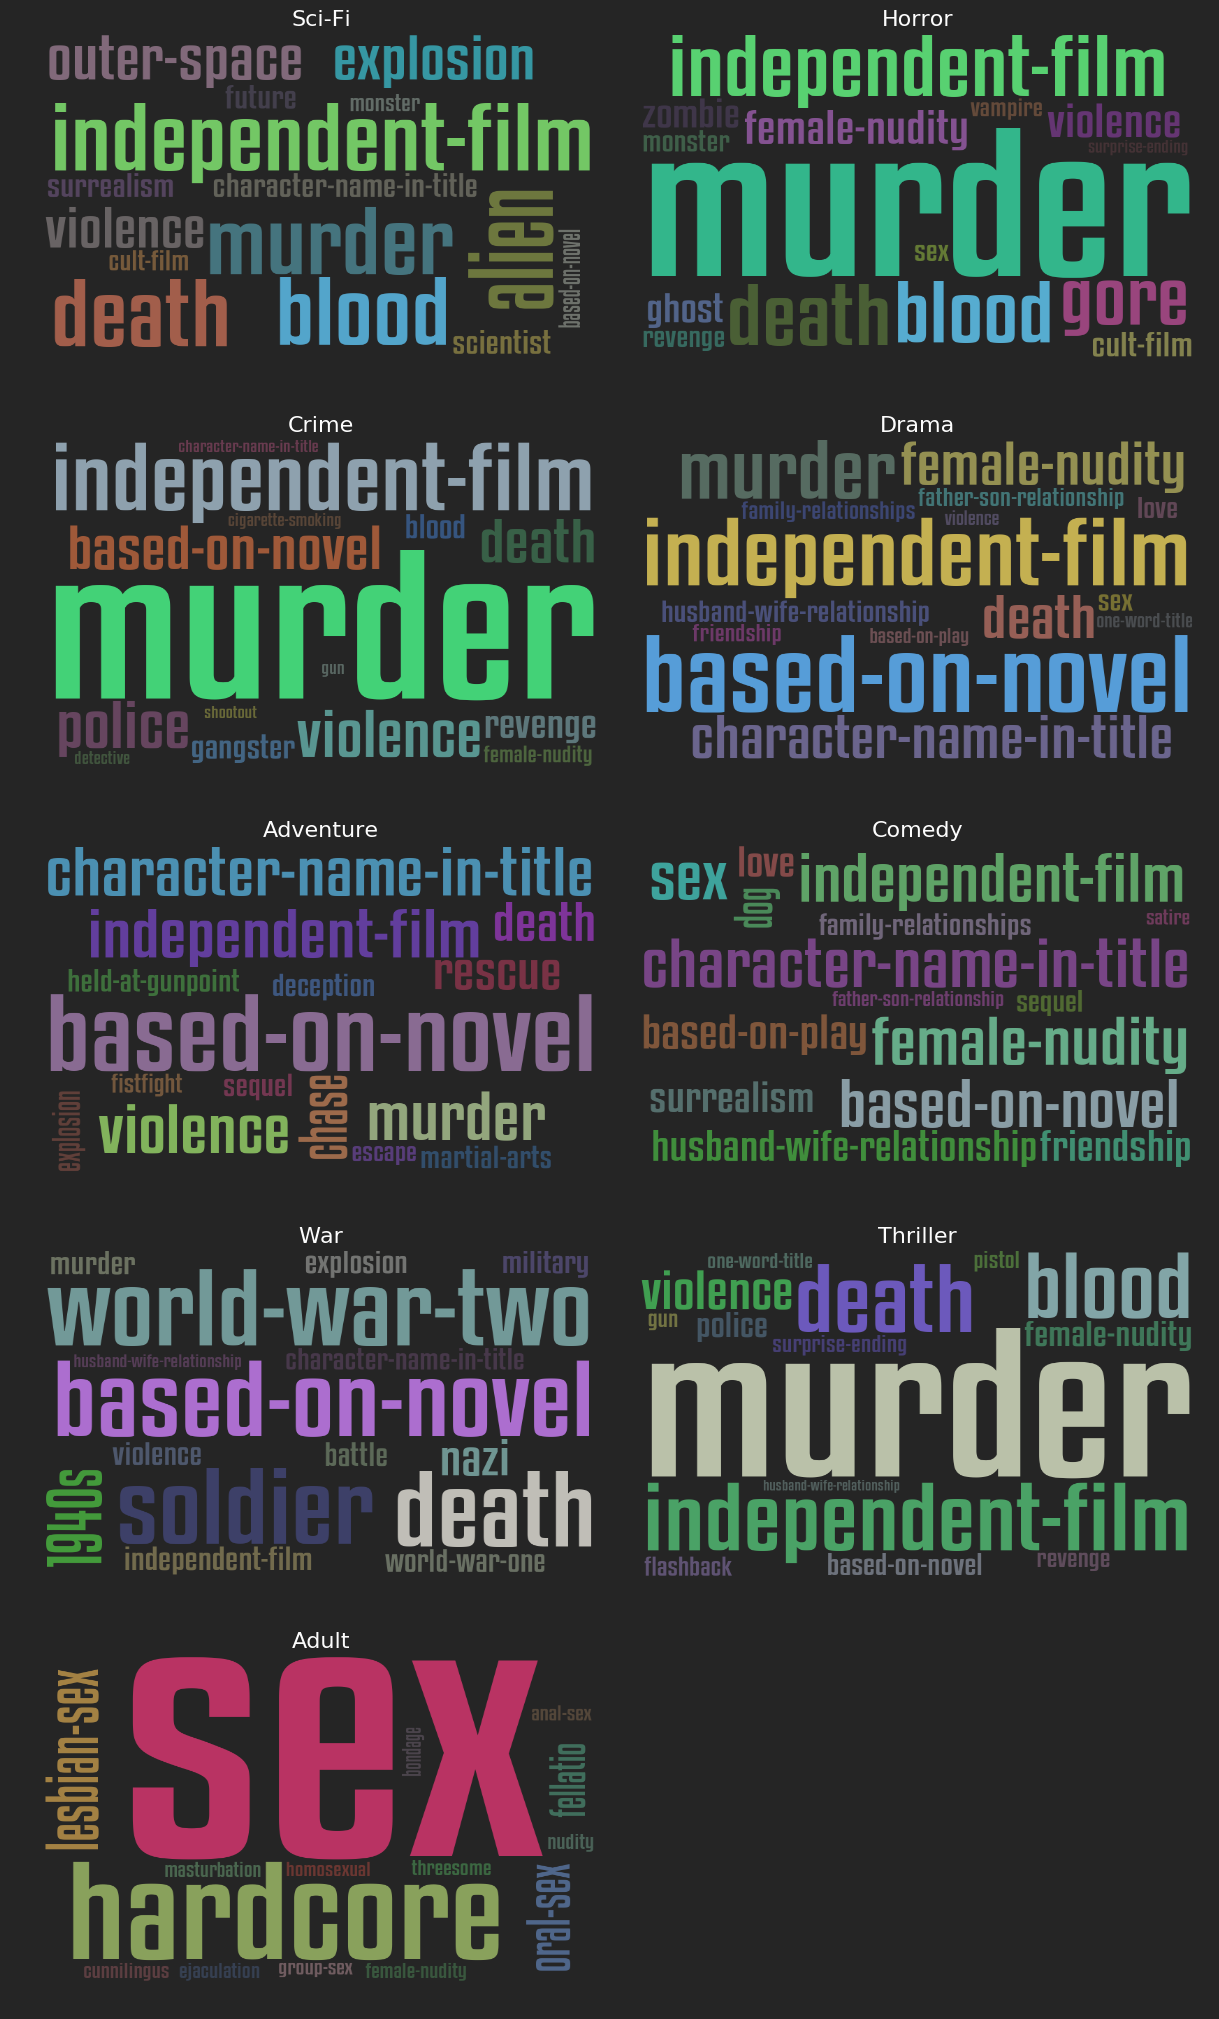

In [10]:
feat.wordclouds(most_common_by_genre(keywords, genres_filter))

In our opinion, the most of the highlighted words correlate with genres they are common in, see science fiction, where common words are *alien*, *outer-space*, *monster*, *robot* and many others which are mainly used across science fiction pictures. Words *death*, *explosion*, *murder*, *violence* and *blood* are very common in many genres of cinematography, but in our case they indicate that the most science fiction pictures show some kind of violence, as a human is xenophobic towards "unknown". There are some few peaceful sci-fi films, and who knows, maybe they will become more popular next years when the science fiction saturates. Horror films are mainly about murder, death, blood and scream. Crime films about murder and police. The murder is also very frequent in dramas. The least describing terms are found in comedy, where almost no concrete terms describe the genre completely (if you are curious which terms are unique for a specific branch, perform tf-idf analysis like we do it below). War films commonly show WWII, and adult films... figure out by yourself. The next interesting area to discover are top films by imdb rating, budget and gross. Keywords used in most profitable films might be representative for them and attract some success. Let us check this out. We will first collect the data of different measures, sort them in descending order to get the highest ones, extract and flatten sets of keywords used across all films in top lists, and finally count them. We've encapsulated the entire logic into a method, as we will use it later on when we work with plot keywords.

In [11]:
def top_250_by(t_coll, tokens_dict):
    top_250 = {
        title: sorted(
                [
                    (id, v) 
                    for id, vs in mongo.collect(collection, filter={'id': {'$in': tokens_dict.keys()}}).iteritems() 
                    for v in vs
                ], 
                key=lambda x: x[1], 
                reverse=True
            )[:250]
        for title, collection in t_coll.iteritems()
    }
    intsct_matrix = np.zeros(shape=(len(top_250), len(top_250)), dtype=int)
    for i, (genre1, lst1) in enumerate(top_250.iteritems()):
        for j, (genre2, lst2) in enumerate(top_250.iteritems()):
            intsct_matrix[i,j] = len(set.intersection(set(zip(*lst1)[0]), set(zip(*lst2)[0])))
    print pda.DataFrame(intsct_matrix, index=top_250.keys(), columns=top_250.keys())
    top_250_counter = {
        k: Counter([
            token
            for id, _ in vs
            for token in tokens_dict[id]
        ])
        for k, vs in top_250.iteritems()
    }
    tab = Table()
    tdata = []
    for genre, counter in top_250_counter.iteritems():
        tdata.append((genre, sum(counter.values()), len(counter), len(counter)/sum(counter.values())))
    tab.from_tuples(tdata, columns=['Dataset', 'Tokens', 'Unique', 'Lexical diversity'])
    tab.display()
    return top_250, top_250_counter

In [12]:
top_250, keywords_top_250_counter = top_250_by(
    {
        'Top 250 by rating': 'imdb_ratings', 
        'Top 250 by budget': 'budgets', 
        'Top 250 by gross': 'gross'
    }, 
    keywords
)

                   Top 250 by budget  Top 250 by rating  Top 250 by gross
Top 250 by budget                248                  0               139
Top 250 by rating                  0                250                 0
Top 250 by gross                 139                  0               250

             Dataset  Tokens  Unique  Lexical diversity
0   Top 250 by gross   49650   14326           0.288540
1  Top 250 by budget   47491   12667           0.266724
2  Top 250 by rating    1723    1274           0.739408



The first table shows the number of movies the lists share. The second one shows the number of unique tokens in each list, but also their lexical diversity. We notice a very high lexical diversity for tokens in 250 top-rated movies list, which is almost 3 times higher than for other lists. That is, top-rated movies have less keywords attached (due to IMDB police or somewhat similar). But we will also see in the distribution below that the most profitable movies are biased towards particular theme elements. Most expensive and highest-grossing films also share the half of the movies, meaning their keyword distributions have to be very similar. Further we will display top keywords in each list by a wordcloud.

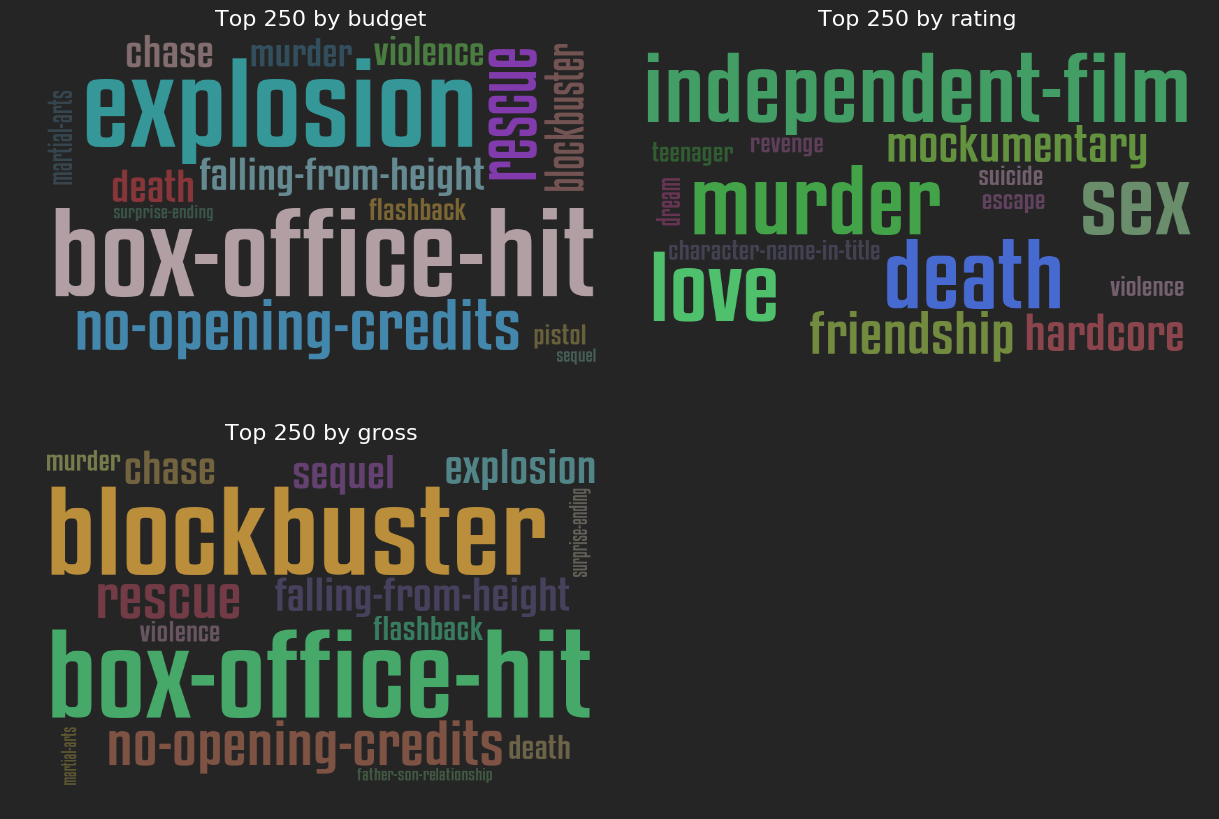

In [13]:
feat.wordclouds({k: c.most_common() for k, c in keywords_top_250_counter.iteritems()})

*Explosion* is THE word for the most most expensive science fiction movies. No wonder. The more a production company has money, the more it invests in special effects, and the more explosions it shows. But it doesn't mean that the most expensive movie automatically becomes a box office hit, as the term *explosion* is not the most frequent one across top 250 films by gross. Here, the most promising are blockbusters. *box-office-hit* keyword (which is self-describing for very successful movies) is also the most common in top 250 films by budget; the reason why those movies in both lists correlate is a big intersection set (~50%). Interesting, but the keyword is less common for movies with the highest IMDB ratings, where the audience prefers independent films (which are mainly low-budget films) and keywords *mockumentary* (parody), *love*, *death*, and *murder*. Next we will pick top 10 keywords from each top list and compare them together on a plot. For this, we will convert all counts into frequencies as token sets in each list differ.

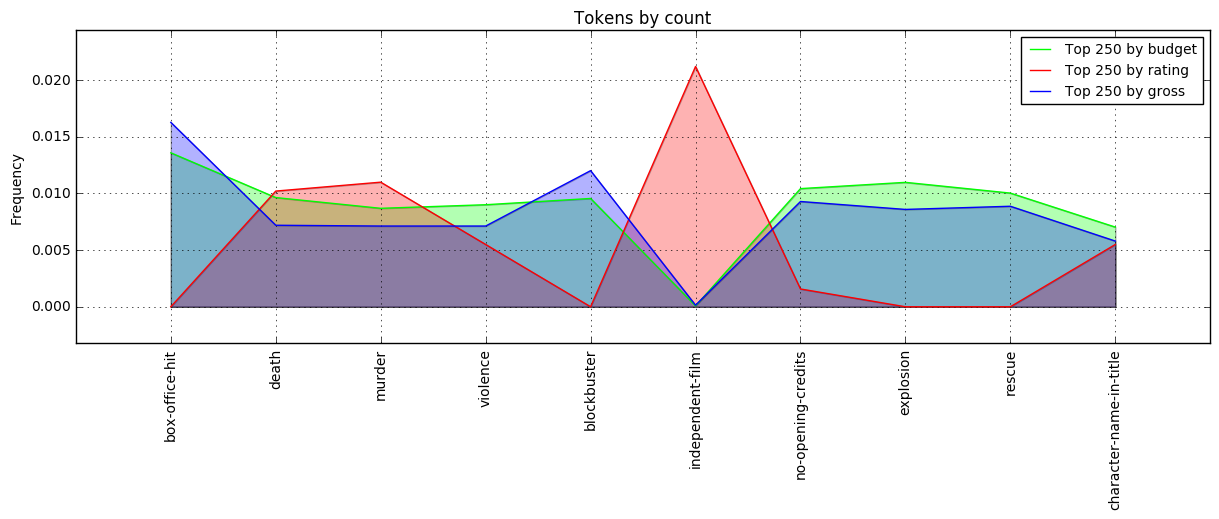

In [14]:
feat.plot_tokens_freq(
    {
        t: {
            id: c/len(counter)
            for id, c in counter.iteritems()
        } 
        for t, counter in keywords_top_250_counter.iteritems()
    }, plt.cm.brg_r, 10)

Plot shows 10 most common keywords in each list. As expected, keywords used in most expensive and highest-grossing films come along, while keywords used in top-rated movies are distributed differently. The reason why the keywords in most expensive and highest-grossing movies correlate is a big intersection set of both top lists. There is an aspect on the plot that suprises us a lot: not only most successful and top-rated films don't correlate, they mirror opposite trends. Take a look at term *independent-film*: almost none of that keyword are present in the keywords set of the most expensive and profitable movies. But on the other side, quite a lot of independent-films are top-rated. The same observation we do wenn we look at word *love*. Quite a lot of top-rated movies are about love, but only a bunch of most successful films are. They interact with feelings of watchers and trigger sympathy.

### Load network

We will use the bipartite projection $M$ from the previous solution, which is a compressed one-mod projection of the bipartite network $Bip$ and which contains movies connected by a common actor, in order to see whether actors tend to act in similar movies. We will calculate similarity based on keywords and plots, average them across edges of each node, and perform assortativity and community analysis: this way we will test the connectivity of movies based on similarity of their contents. Nodes in $M$ are movies of a genre (thus only a subset of all movies from IMDB) selected previously. If genre hasn't changed (we bet it hasn't) then it is **science fiction** which we will work on; otherwise you will be able to identify the genre by keywords in wordclouds (if not then you can throw the analysis in a bin). You are very welcome to test out other genres by setting a desired one in the third part of the solution.

In [15]:
M = net.read_graph('./data/M')


       N       L  Components  Larg. component         C       p  k_min  k_max  \
0  13989  127209           1            13989  0.358204  0.0013      1    343   

   k_median     k_mean  
0       6.0  18.187004  



Because some of the movies in $M$ are missing in the "keywords" collection, we fetch identifiers of movies which provide keywords, and extract a new GCC from $M$. This way we get a graph containing only movies which have keywords.

In [16]:
MK = net.network_area(M.subgraph(keywords.keys()))


      N      L  Components  Larg. component         C         p  k_min  k_max  \
0  5955  85191           1             5955  0.321124  0.004805      1    318   

   k_median     k_mean  Time (sec)  
0      15.0  28.611587    1.285932  



Around half of the nodes were removed after this operation. Notice how $k_{mean}$ and $p$ have increased: because the most of the movies without keywords are less known, they are also less connected with others, thus mainly nodes with poor connectivity were removed. Next we fetch the actual keywords based on nodes in $M$. Why didn't we do this operation first? By limiting the network to GCC some of the nodes get lost, thus we must have filtered the keywords based on the refreshed set of movies again.

In [17]:
genre_keywords = { 
    id: kwds
    for id, kwds in keywords.iteritems()
    if id in MK
}

### Similarity matrix

Next we want to test the similarity of film contents based on keywords. We do this by vectorization, which is the general process of turning a collection of text documents into numerical feature vectors. Documents in our case are sets of keywords that are described by keyword occurrences while completely ignoring the relative position information of the keywords in the set. As result, a tf-idf matrix will be built, where documents (movies) are represented as row (horizontal) vectors, and features (keywords) as column (vertical) vectors. Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency. In "keywords" collection some keywords will be very present (e.g. “war”, “explosion”, “terror”) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.  The tf-idf value helps to adjust for the fact that some of those keywords appear more frequently in general. As most documents will typically use a very small subset of the keywords, the resulting matrix will have many feature values that are zeros. We will rely on a self implementation rather than use `sklearn.feature_extraction.text.CountVectorizer`, as we were able to develop a faster approach and to make it accessible for a wider set of problems. The method above vectorizes documents, which are sets of keywords, and returns a sparse matrix of type `scipy.sparse.csr_matrix` and two maps: the converse mapping from feature name to column index is stored in the feature index, from the document name to row index in the document index.

In [18]:
KV, doc_index_KV, feature_index_KV = feat.vectorize_documents(genre_keywords)


   Documents  Features  Time (sec)
0       5955     32660    4.690054



We see number of documents is the same as number of movie nodes in $M$, that's what we actually wanted. The number of features is 32660, which is 5.48 features per document. Next we will use `sklearn.metrics.pairwise.cosine_similarity` to calculate cosine similarity matrix, i.e., similarity between each pair of documents. The method returns the matrix in a dense format rather than sparse as the half of the documents is somehow similar and their cosine similarity is nonzero.

In [19]:
cosim_KV = feat.sparse_cosim(KV)


          Shape  Time (sec)
0  (5955, 5955)     0.79583



This is a square matrix, where documents (movies) are represented both as rows and columns. Value $X[i,j]=1$ means that documents at $i$ and $j$ are perfectly similar. To get a feel how values in the similarity matrix are distributed, let us visualize their distribution on a plot.

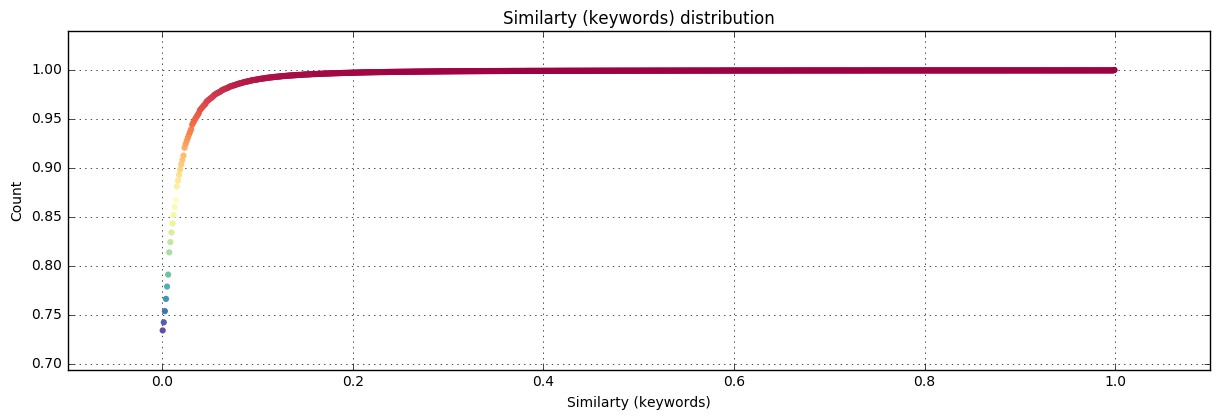

In [20]:
feat.plot_dist(cosim_KV.flatten(), plt.cm.Spectral_r, 'Similarty (keywords)', cumulative=True)

We see that the most documents aren't similar at all, while a little bunch of them really are. We are interested in those most similar documents. What we do further is testing similarity on an example movie.

### Test on a root movie

The example movie we've chosen is the *The Martian (2015)*. Let's see what are the similar movies to this one based on plot keywords.

In [21]:
def movie_id(title, release_year):
    '''Return movie_id by title and release year'''
    ids_by_year = [d['id'] for d in mongo.db.release_years.find({'info': release_year})]
    movie_ids = [d['id'] for d in mongo.db.titles_map.find({'id': {'$in': ids_by_year}, 'info': {'$regex': '.*%s.*'%title}})]
    if movie_ids:
        print ', '.join(map(str, movie_ids))
        return next(iter(movie_ids or []), None)
    else:
        None

In [22]:
root_movie = movie_id('The Martian', 2015)

3780540


For this, we call the method `FeatureHelper.most_similar_to`, which takes a similarity matrix, document index and a document as arguments, and returns the vector corresponding to that document as a dictionary with similarity keyed by related document. 

In [23]:
root_similar_KV = feat.most_similar_to(cosim_KV, doc_index_KV, root_movie)


   Similar documents  Time (sec)
0               3238    0.015778



Column "Similar documents" shows number of documents with similarity $sim>0$. Next we will display all related documents along with related information on similarity and whether movies are connected in $M$.

In [24]:
def title(node):
    t = mongo.collect('titles_map', filter={'id': node})
    return (t[node][0] if len(t[node][0])<=30 else t[node][0][:30]+'...') if t else ''
def year(node):
    y = mongo.collect('release_years', filter={'id': node})
    return int(y[node][0]) if y else ''

In [25]:
def display_similar(G, root_movie, root_similar, corpus, n):
    tab = Table()
    tdata = [('Source', root_movie, title(root_movie), year(root_movie), 1.0, '', '', '')]
    for i, (similar_movie, cos) in enumerate(sorted(root_similar, key=lambda x: x[1], reverse=True)[:n]):
        tokens_intsct = set.intersection(set(corpus[root_movie]), set(corpus[similar_movie]))
        frac = len(tokens_intsct)/len(set(corpus[root_movie]))
        tdata.append(('Target' if i==0 else '', similar_movie, title(similar_movie), 
                      year(similar_movie), cos, tokens_intsct, frac, similar_movie in G.neighbors(root_movie)))
    tab.from_tuples(tdata, columns=['Element', 'ID', 'Title', 
                                    'Year', 'Similarity', 'Shared tokens', 'Fraction', 'Connected'])
    tab.display()

In [26]:
display_similar(MK, root_movie, root_similar_KV, genre_keywords, 5)


  Element       ID                    Title  Year  Similarity  \
0  Source  3780540              The Martian  2015    1.000000   
1  Target  3120606                  Gravity  2013    0.097388   
2          3045469            Europa Report  2013    0.094535   
3          2789431  Approaching the Unknown  2016    0.093591   
4          3768899    The Last Days on Mars  2013    0.090691   
5          3206622             Interstellar  2014    0.089524   

                                       Shared tokens   Fraction Connected  
0                                                                          
1  {female-astronaut, earth-viewed-from-space, mi...    0.13617      True  
2  {zero-gravity, reference-to-neil-armstrong, ea...  0.0680851     False  
3  {mission-control, colonization, nasa, astronau...  0.0297872     False  
4  {sand-storm, female-astronaut, space, mars-bas...  0.0595745     False  
5  {food-shortage, bomb, earth-viewed-from-space,...   0.165957      True  



The table shows the source movie *The Martial (2015)* and top 5 target movies similar to it based on keywords. We've included many pieces of valuable information and measures. We see that the *The Martian* is related to movies like *Gravity (2013)* and *Interstellar (2014)* which (in our opinion) are very content-similar. The next aspect we discover is that all displayed movies were made after year 2013, meaning they also time-window-related and fresh. In "Shared tokens" column we can observe the keywords shared by related movies. For example, *The Martian (2015)* and *Interstellar (2014)* share keywords *food-shortage*, *bomb*, *earth-viewed-from-space*, and more, resulting in a fraction of shared keywords of 0.16, that is, they share 17% of keywords representing the source movie. It's a very tiny fraction, but still does the job. What we also see is that both films are connected in $M$, i.e., common actors (to be specific *Matt Damon (1970)* and *Jessica Chastain (1977)*) played in both movies. And that is what we want to check: are movies connected through an actor content-related? We will dig into assortativity and answer this question later on. Now let us visualize the keywords used in *The Martial (2015)*. Those keywords are sorted by a tf-idf value, that is, the bigger the terms in a wordcloud are, the more unique there are for this particular film, and the more uncommon they are for other films.

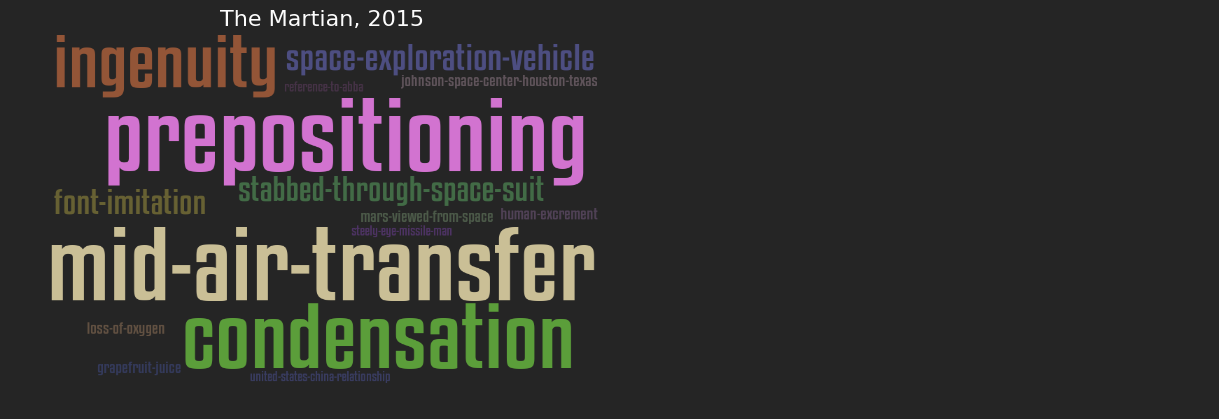

In [27]:
feat.wordclouds({
    '%s, %d'%(title(root_movie), year(root_movie)): feat.transform_vector_wordcloud(feat.document_vector(KV, doc_index_KV, feature_index_KV, root_movie)), 
})

The wordcloud shows us those keywords that make the movie unique among all movies. Maybe these keywords defined success of that movie? You are welcome to check this out. We don't see very familar terms like "space", "future", and related (which are a bit... boring). Instead, it returns some very unique terms *space-exploration-vehicle*, *mid-air-transfer*, *prepositioning* and *condensation*, which are more representative. That is, having seen those terms anywhere, you will be able to identify the *The Martian (2015)* movie without troubles. Next we want to look at "term identifiers " of the most related movie to the source one, again by drawing a wordcloud.

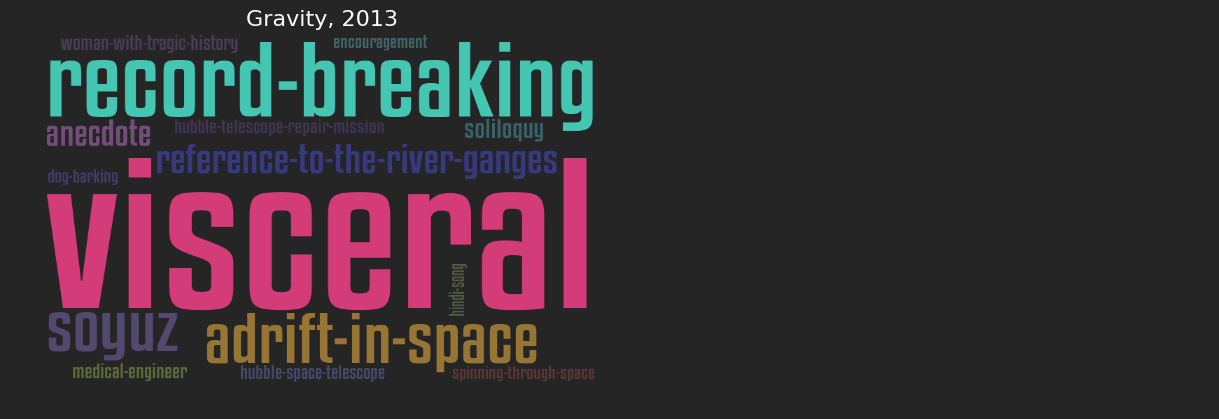

In [28]:
feat.wordclouds({
    '%s, %d'%(title(root_similar_KV[0][0]), year(root_similar_KV[0][0])): feat.transform_vector_wordcloud(feat.document_vector(KV, doc_index_KV, feature_index_KV, root_similar_KV[0][0])), 
})

Those are keywords unique for the *Gravity (2013)* movie. Words *vesceral*, *soyuz*, *adrift-in-space*, *record-breaking* and *radio-interference* represent the film. We all have watched that film and known the *Soyuz* rocket, visceral feelings of the star *Sandra Bullock*, and record-breaking box-office numbers. Next in our analysis queue is network analysis.

### Network analysis

In network analysis we will discover connectivity between similar movies. To do that, we must first calculate similarity for each edge in $M$, and then think about how we can transform the similarity which is an edge attribute to a node attribute. For this, we will take an average of similarity of all connections coming from a node and attach it as a new attribute. Afterwards, we will test the network for an assortativity towards the average similarity and check whether it produces a good partition. Now using the designed method `FeatureHelper.pairs_cosim` we will pass the cosine-similarity matrix, document index and edges as arguments, and become a new dictionary with similarity keyed by an edge in return. The method goes through each pair and picks its similarity from the dense matrix built before.

In [29]:
edge_cosim_MK = feat.pairs_cosim(cosim_KV, doc_index_KV, MK.edges())


   Pairs  Time (sec)
0  85191   36.311901



In the next couple of lines we define a method for averaging similarities of links coming from nodes. As `NetworkX.numeric_assortativity_coefficient` has troubles with float values, we will project them to an integer scale $[1,nclasses]$.

In [30]:
def node_avg_cosim(G, edge_cosim, nclasses):
    avg_cosim = {
        n: int(math.ceil(np.mean([edge_cosim[(n, nb)] for nb in G.neighbors(n)])*nclasses)) 
        for n in G.nodes()
    }
    return {n: v for n, v in avg_cosim.iteritems() if v>0}

In [31]:
node_avg_cosim_MK = node_avg_cosim(MK, edge_cosim_MK, 100)

After getting a dictionary with average similarities keyed by movie identifiers ready, we would like to know what the distribution of average similarities across the nodes in $M$ is, in order to adjust the number of classes for rescaling. Hence we will attach average similarity attribute to nodes in $M$ and plot attribute values ditribution and compare them to degrees.

In [32]:
nx.set_node_attributes(MK, 'avg_cosim_keywords', node_avg_cosim_MK)

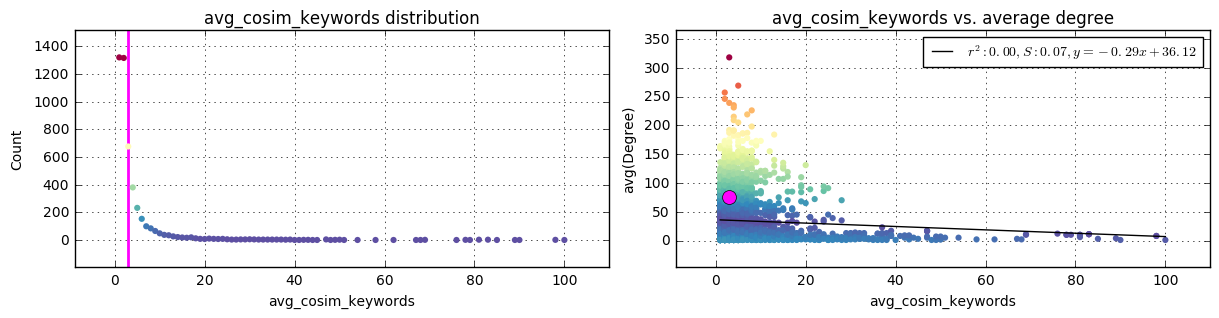

In [33]:
net.plot_attr_dist(MK, ['avg_cosim_keywords'], plt.cm.Spectral_r, root=root_movie)

The distribution with $nclasses=100$ looks promising. There are no connections with zero similarity due to the fact that we filtered them out, but still, the most connections are similar just of a bit (maybe one or two keywords the movies have in common). We also notice that less than 1% of nodes have a rescaled average similarity $sim_{proj}>10$. That's the point we must be careful at: if the distribution is so unequal like this one, assortativity may run into the height as the most nodes are associated with one single class. On the right plot we discover a (almost) linear correlation between average similarities and degrees. This is due to the fact, that the bigger the degree of a node is, the less is the impact of a single similarity on its average similarity. 

In [34]:
net.assortativity(MK, {'avg_cosim_keywords': 'numeric'})


      Type           Attribute     Coef.  Time (sec)
0  numeric  avg_cosim_keywords  0.503546    1.341241
1   degree                      0.272110    1.386181



The assortativity coefficient for the `avg_cosim_keywords` attribute is around 0.5 (which is in medium-range). This may be due to several reasons listed above, but which one is true? We will answer this question when working with plot keywords, but a small spoiler now: average similarity based on plots having almost the same distribution of values show assortativity 2 times lower than this one above, meaning keywords-similar nodes are really more connected. Let us take a look on a visual representation.


    N    L  Components  Larg. component         C         p  k_min  k_max  \
0  59  544           1               59  0.841635  0.317943      1     58   

   k_median     k_mean  Time (sec)  
0      29.0  18.440678    0.031762  

Attribute values: 1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 17, -1


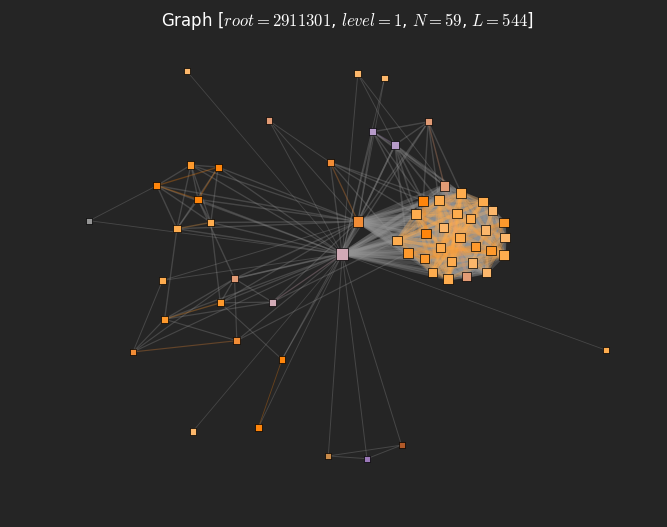

In [80]:
net.draw_graph_attr(
    MK, 
    'avg_cosim_keywords', 
    plt.cm.Paired,
    depth=1
)

We observe some clear pattern across nodes: nodes of same color tend to be connected together. This means that movies connected through the same actor are in some cases content-similar. This proves the hypothesis just partly: at least a bunch of actors play in content-related pictures. But what about modularity? Does the average similarity reflect the structure of the network? For this, calculate the modularity.

In [36]:
net.modularity(MK, ['avg_cosim_keywords'])


            Attribute  Communities         M  Time (sec)
0  avg_cosim_keywords           66  0.041516     1.35742



The modularity is near zero, meaning movies of different average similarity classes have more connections in common than the movies within one average similarity class. This was expected, as different connections are established by different actors, and some of the are more willing to diverse their cinematic portfolio, and some rather not. Therefore, the diversity of similarities across edges make the boundaries of communities weak and modularity drops.

### Similarity vs other attributes

Another interesting aspect of average similarities is that they as legal node attributes are comparable to other attributes and we are able to compare them all using beautiful plots. We will use only those attributes which have an absolute zero on the values scale.

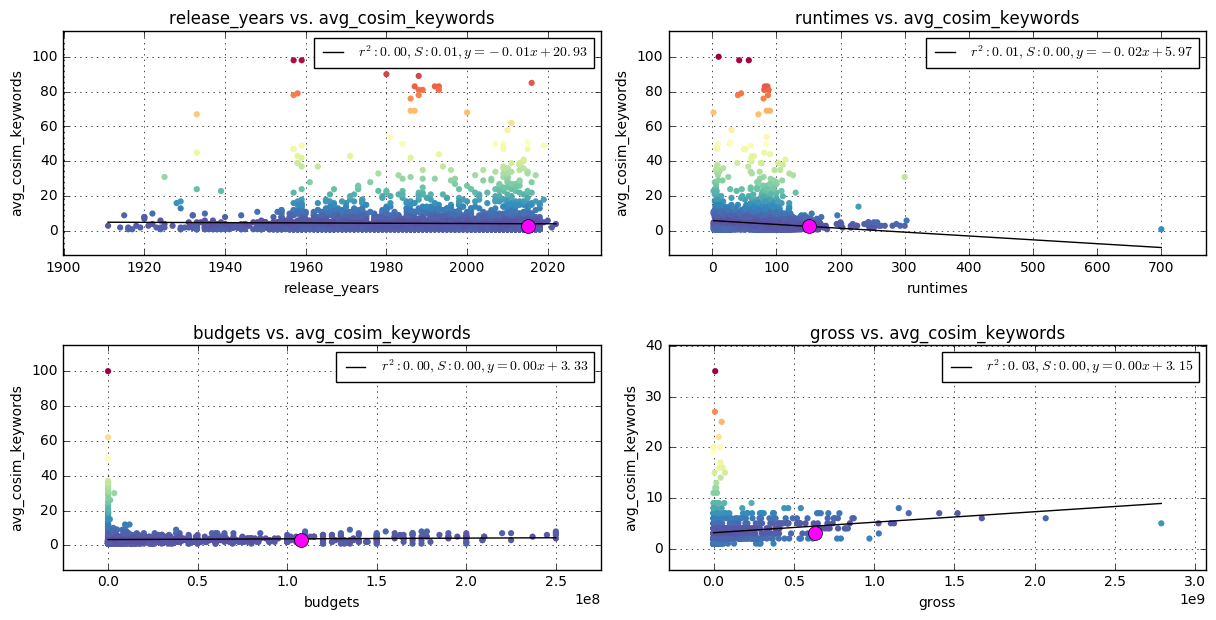

In [37]:
net.plot_attr_vs_attr(
    MK, 
    [
        ('avg_cosim_keywords', 'release_years'),
        ('avg_cosim_keywords', 'runtimes'),
        ('avg_cosim_keywords', 'budgets'),
        ('avg_cosim_keywords', 'gross')
    ],
    plt.cm.Spectral_r, 
    root=root_movie
)

As seen on the plots, there is no single attribute correlated with average similarity. This means that actors in older days have done the same choice as nowadays. This doesn't suprise us, as average similarity depends on a dicision of an actor rather than on a movie. This decision isn't depending upon year, nor it is depending upon gross, budget and other measures: it is an output of complex psychology of an actor. But as we have seen above the average similarity also depends upon degree (because of average calculation), which is an additional distraction factor to correlation with all kinds of attributes.

## Plots

### Most common

We will do the same calculations as for keywords, with one single exception: plots need to be additionality tokenized and cleaned. Compared to the section where we analyze keywords, we have here the method `FeatureHelper.tokenzie`, which extracts all words using `nltk` library, converts them to lower case, removes stopwords, but also filters words which are not nouns or adjectives. This way we get rid of all *on*, *and*, *tomorrow*, etc. terms and let only objects and attributes in the output.

In [38]:
plots = {
    id: plts
    for chunk in chunks(ids_filter, 1000)
    for id, plts in mongo.collect('plots', filter={'id': {'$in': chunk}}).iteritems()
}

In [39]:
plot_keywords = {
    id: [
        token
        for token in set(feat.tokenize(' '.join(plts), tags=['NOUN', 'ADJ']))
    ] 
    for id, plts in plots.items()
}

As usual we do some basic analysis first to discover some very common terms across all genres. For this we count each token across all plots and draw a beautiful wordcloud.

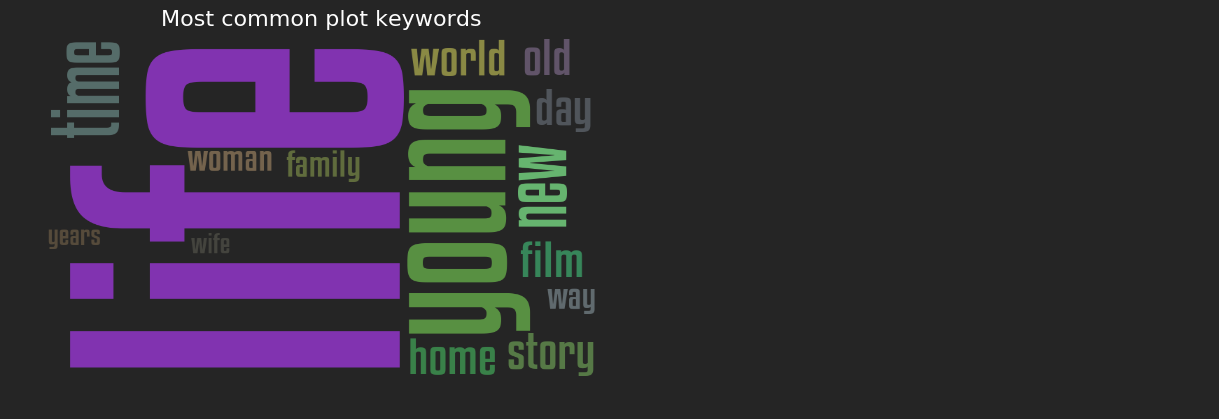

In [40]:
feat.wordclouds({
    'Most common plot keywords': Counter([token for tokens in plot_keywords.values() for token in tokens]).most_common()
})

Those words are the most frequent terms in movie plots. They contain a lot of general information, and depending upon language of a writer of those plots and how he expresses himself. On the top is word *life*, which is the most central element of all movies - a human. The second term is *young*: maybe it is all about teens playing in movies, or about the story the movie tells. Other keywords are also of a small entropy - they do not deliver any valuable information. Next we will group keywords by genre to discover how they differ and present the most common of them using wordclouds.

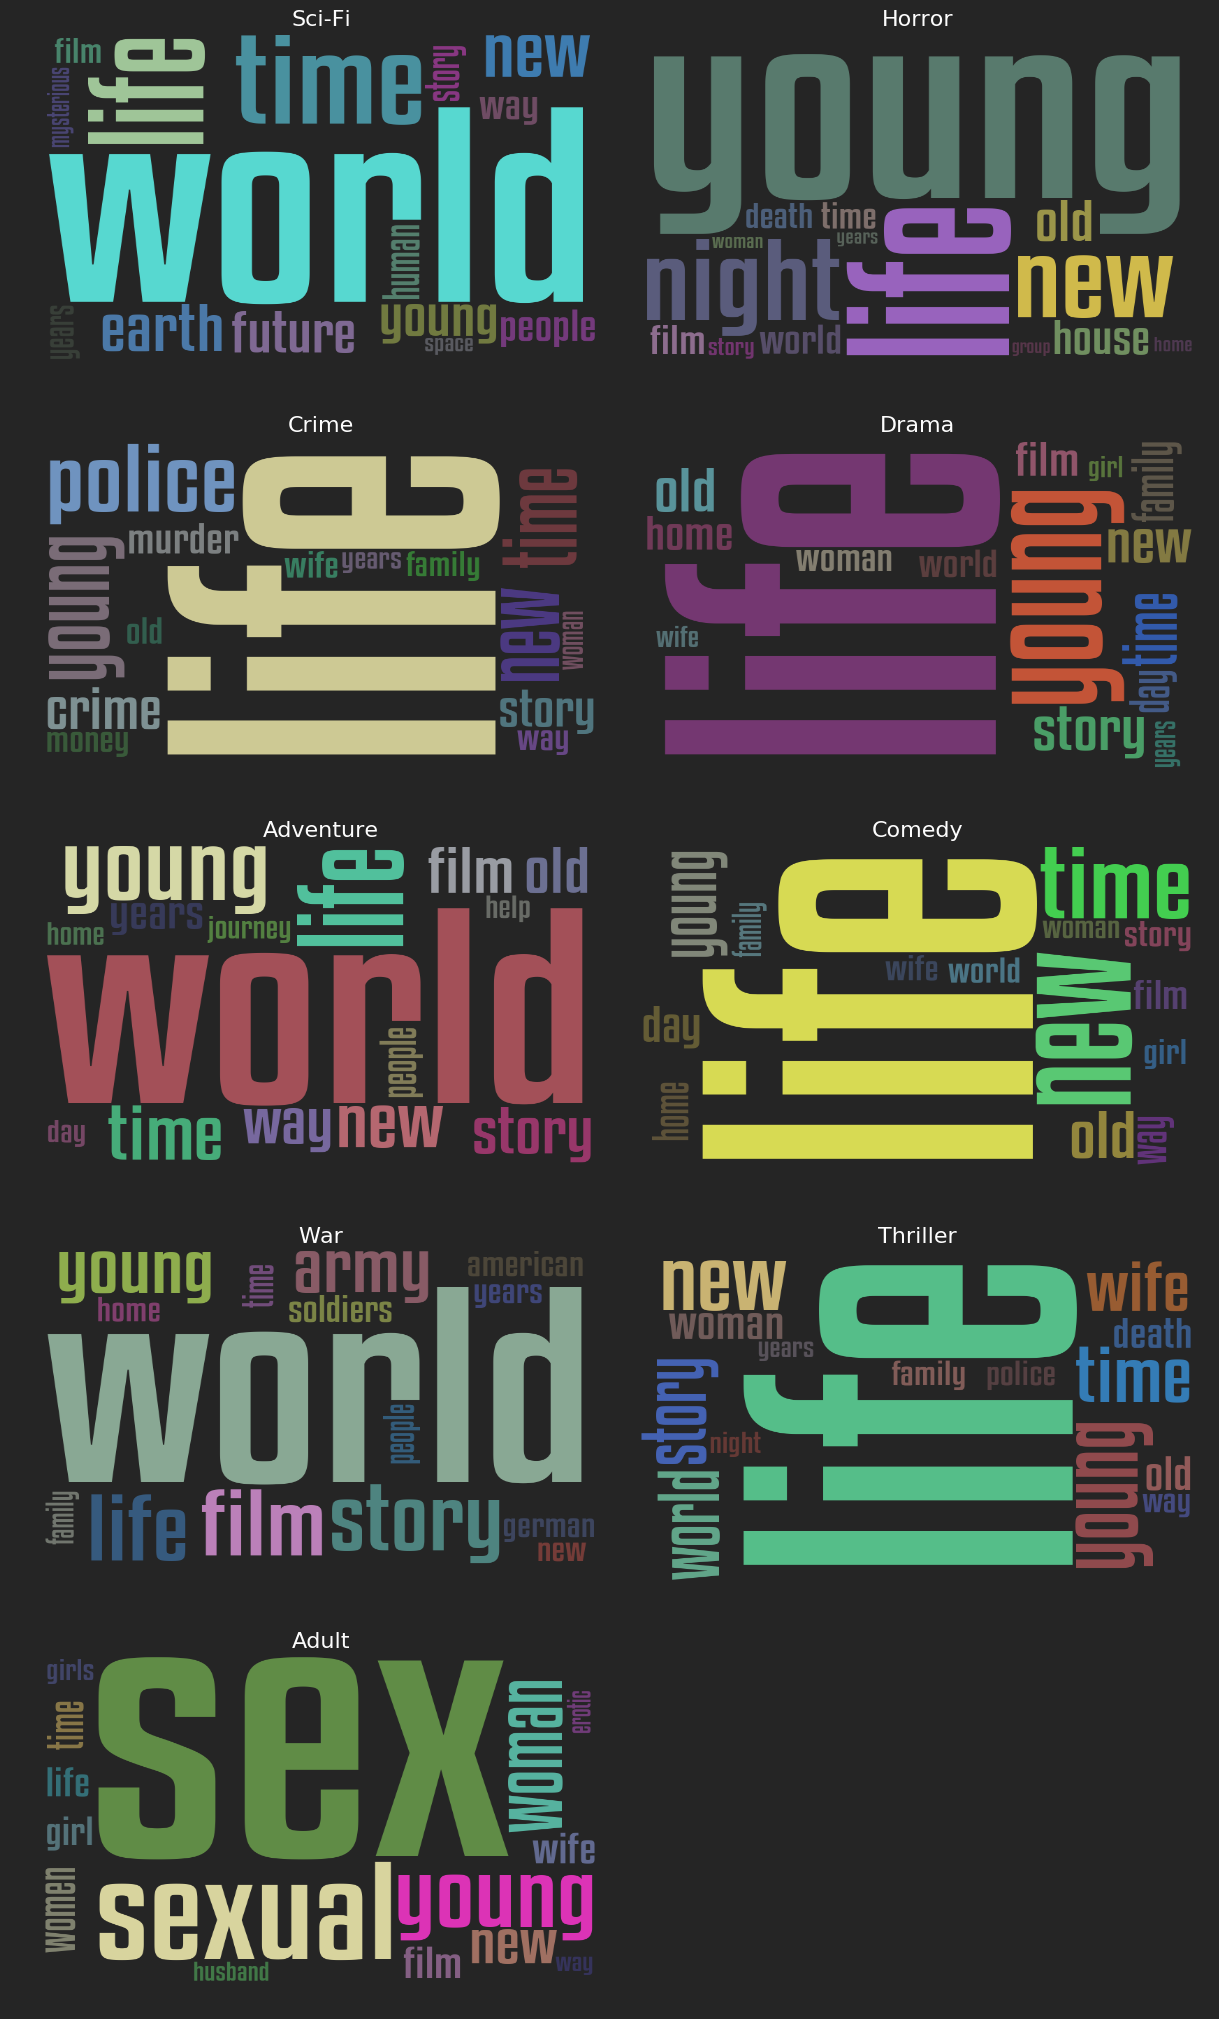

In [41]:
feat.wordclouds(most_common_by_genre(plot_keywords, genres_filter))

We see that terms in the wordcloud are less informative as we had this before, due to the fact that the plots are less concrete than provided keywords. Plots also contain many very common words which are very hard to filter (like *world*, *life*, *new*, etc above). The only genres where plots are a bit more informative seem to be adult movies. But let us dig a bit deeper... Do you see that pattern? Movies which show wide horizonts, focus on big stories, on wars, on everything that touches the whole humanity - they have the term *world* in common. While those movies that tell story of some particular individuals mostly use in plots word *life*. While keywords provided very specific information on each movie, plots can uncover keywords of the entire genre: *new*, *world*, *life*, *time*, *planet*, *future*, they all are the top keywords of the genre science fiction, which are pretty representative. For example, from [Wikipedia](https://en.wikipedia.org/wiki/Science_fiction): science fiction is a genre of speculative fiction typically dealing with imaginative concepts such as **futuristic** science and technology, **space** travel, **time** travel, faster than light travel, parallel universes, and extraterrestrial **life**. Hence discovering more abstract things is also an opportunity to obtain some new knowledge. This just proves that every piece of information is highly valuable and can explain a bit more about what is going on behind the scenes. But how do we calculate the similarity of documents (plots) if many of them contain redundant information? The only relief we can achieve is to build a tf-idf matrix, what we do later. Below we extract plot tokens from movies in each top 250 list and create already familiar wordclouds based on their counts.

In [42]:
top_250, keywords_top_250_counter = top_250_by(
    {
        'Top 250 by rating': 'imdb_ratings', 
        'Top 250 by budget': 'budgets', 
        'Top 250 by gross': 'gross'
    }, 
    plot_keywords
)

                   Top 250 by budget  Top 250 by rating  Top 250 by gross
Top 250 by budget                248                  0               141
Top 250 by rating                  0                250                 0
Top 250 by gross                 141                  0               250

             Dataset  Tokens  Unique  Lexical diversity
0   Top 250 by gross   23620    7608           0.322100
1  Top 250 by budget   20557    6930           0.337111
2  Top 250 by rating    6791    3412           0.502430



As seen when working with keywords, plots for 250 top-rated movies have a higher diversity than for movies in other lists. That is, plots of top rated movies are more diverse and use more terms. As before, the list of most expensive films and the list of highest-grossing films share more than the half of the movies, meaning their keyword distributions intersect. Further we will display top keywords in each list by a wordcloud.

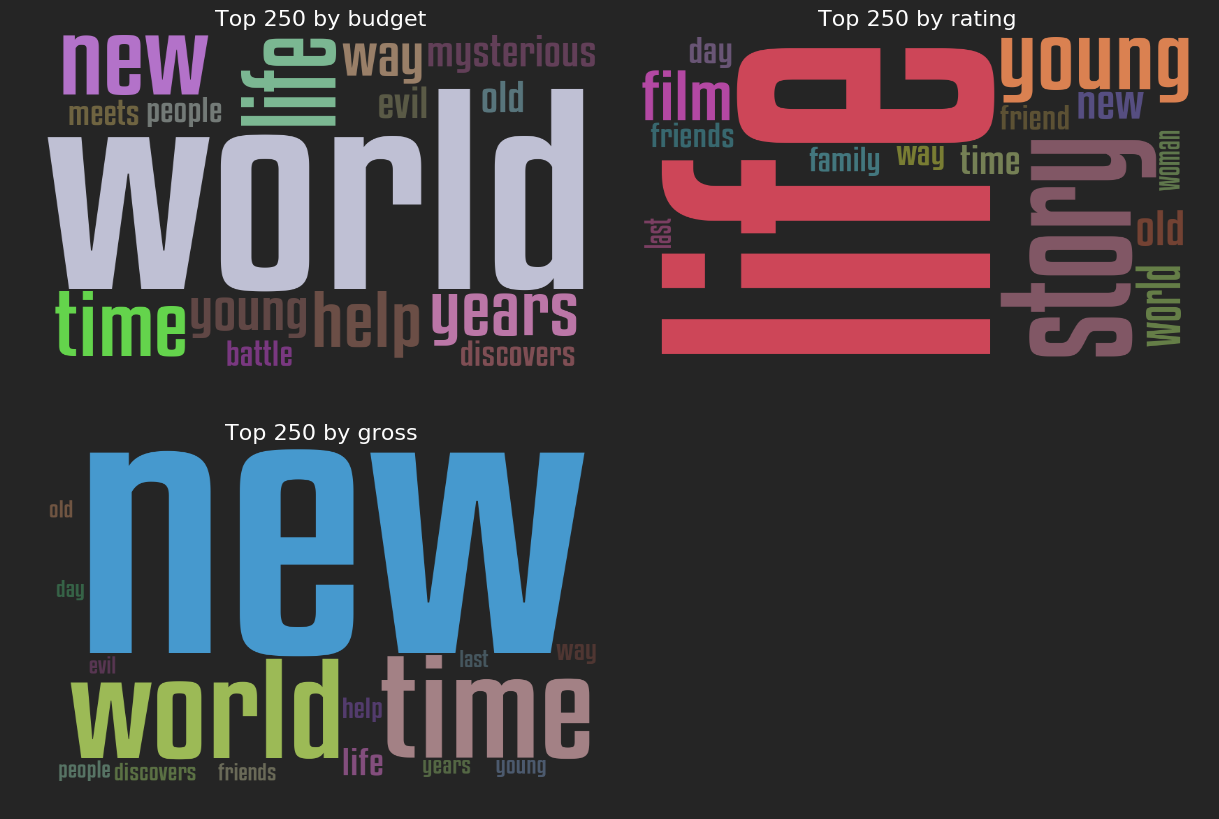

In [43]:
feat.wordclouds({k: c.most_common() for k, c in keywords_top_250_counter.iteritems()})

There is just a little differenc between those lists, the most common words in each list are also pretty common in each other. The most expensive films tend to show a global picture and operate on a world level, they may try to include many scenes in many countries for the money they have. The top rated movies tend to tell some breathtaking stories and this way get in touch with feelings of audience. Highest-grossing films tend to deliver some new content. Before we get more specific, let's discover the count distribution of tokens in the meanwhile.

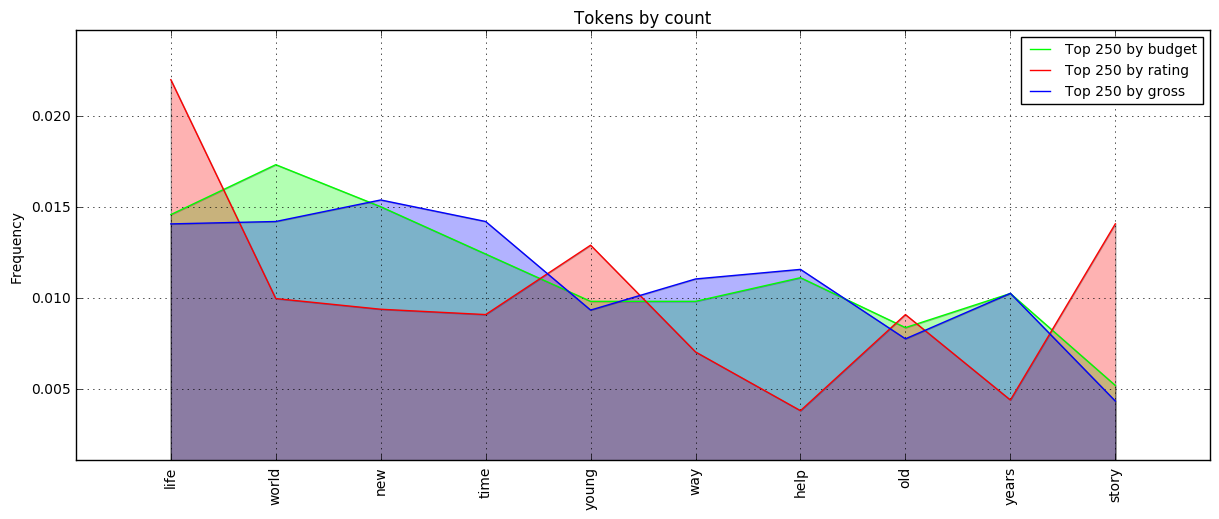

In [44]:
feat.plot_tokens_freq(
    {
        t: {
            id: c/len(counter) 
            for id, c in counter.iteritems()
        } 
        for t, counter in keywords_top_250_counter.iteritems()
    }, plt.cm.brg_r, 10)

We recognize a similar picture to keywords analyzed before: the top-rated films and the most expensive and successful films show opposite trends ragarding plots. Top-rated movies tend to tell stories about individuals and their destinies, while the most profitable ones provide new contents (*new*) and show a more global picture (*world*). Next we will calculate similarities of movies based on their plot's keywords.

### Load network

We will perform network analysis on a separate network area called $MP$. $MP$ is a subgraph of $M$ with nodes which provide information on plots.

In [45]:
MP = net.network_area(M.subgraph(plot_keywords.keys()))


      N      L  Components  Larg. component        C         p  k_min  k_max  \
0  5391  63070           1             5391  0.29939  0.004341      1    259   

   k_median     k_mean  Time (sec)  
0      10.0  23.398256    1.002499  



We create a new variable `genre_plot_keywords` containing only plot keywords of movies in $MP$.

In [46]:
genre_plot_keywords = { 
    id: kwds
    for id, kwds in plot_keywords.iteritems()
    if id in MP
}

### Similarity matrix

Next we want to test the similarity of film contents based on plot keywords. We do this in the manner we did it before - by vectorization.

In [47]:
PV, doc_index_PV, feature_index_PV = feat.vectorize_documents(genre_plot_keywords)


   Documents  Features  Time (sec)
0       5391     26214    4.405089



Next we will use `sklearn.metrics.pairwise.cosine_similarity` to calculate cosine similarity matrix, i.e., similarity between each pair of documents and plot its distribution.

In [48]:
cosim_PV = feat.sparse_cosim(PV)


          Shape  Time (sec)
0  (5391, 5391)    0.796169



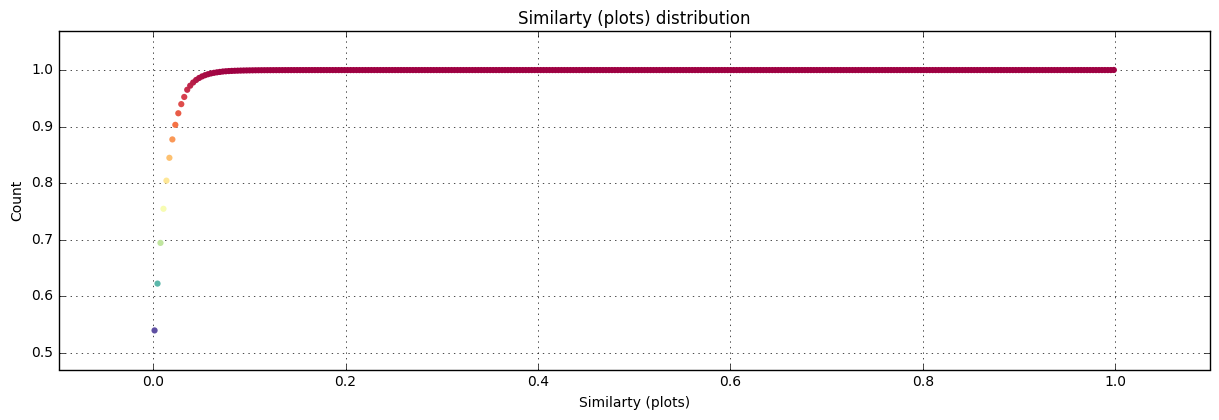

In [49]:
feat.plot_dist(cosim_PV.flatten(), plt.cm.Spectral_r, 'Similarty (plots)', cumulative=True)

We see that the most documents have zero similarity. The little heap around the value 0.01 may indicate the normal distribution of similairties, but the problem with normality is that it doesn't allow a wide range of values, thus we throw that assumption in the bin. What we do further is testing similarity on an example movie (which was selected in the section where we explore keywords).

### Test on a root movie

In [50]:
root_similar_PV = feat.most_similar_to(cosim_PV, doc_index_PV, root_movie)


   Similar documents  Time (sec)
0               4748    0.031693



In [51]:
display_similar(MP, root_movie, root_similar_PV, genre_plot_keywords, 5)


  Element       ID                    Title  Year  Similarity  \
0  Source  3780540              The Martian  2015    1.000000   
1  Target  3367285          Mars and Beyond  2000    0.145103   
2          3662658             Star Crystal  1986    0.109740   
3          3670241                 Stranded  2001    0.102572   
4          3572163  Robinson Crusoe on Mars  1964    0.092716   
5          3573415          Rocket-bye Baby  1956    0.089492   

                                       Shared tokens   Fraction Connected  
0                                                                          
1  {dangerous, mars, year, mission, astronauts, p...  0.0775862     False  
2  {missions, space, alive, martian, surface, mem...  0.0689655     False  
3  {forced, life, help, due, team, mars, mission,...   0.155172     False  
4  {survives, needs, short, forces, mars, plant, ...    0.12931     False  
5      {ingenious, try, martian, green, mars, earth}  0.0517241     False  



The table shows the source movie *The Martial (2015)* and top 5 target movies similar to it based on plot keywords. *The Martian* is related to other movies by plot keywords *missions*, *space*, *astronauts*, *mars*, and so on. Those terms are more general than keywords before, hence more movies must fall under the category "similar". The movies in the list are also disconnected in $M$, that is, the connectivity between similar movies based on plot keywords is lower than based on keywords. Keywords are simply a better measure. Next we visualize the document tf-idf vector by a wordcloud.

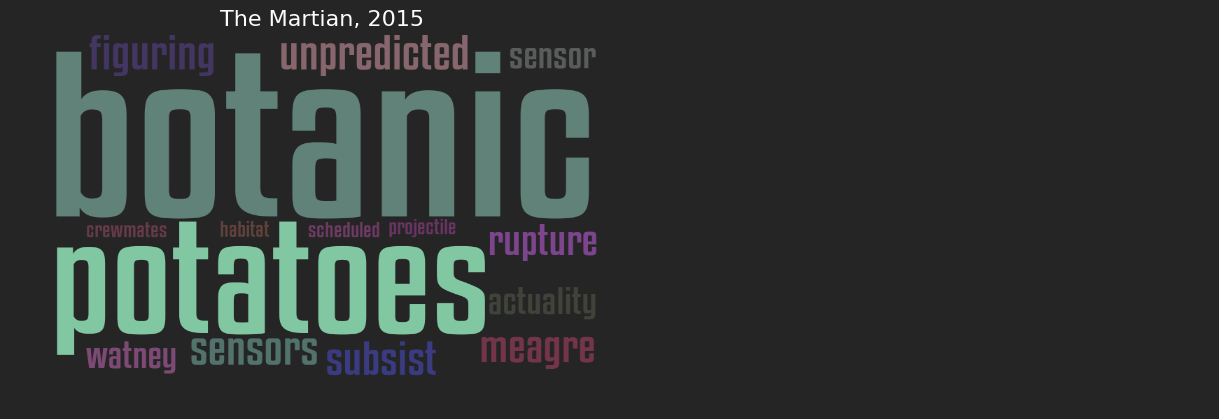

In [52]:
feat.wordclouds({
        '%s, %d'%(title(root_movie), year(root_movie)): feat.document_vector(PV, doc_index_PV, feature_index_PV, root_movie)
    })

Terms *meagre*, *botanic* and *potatoes*, are they descriptive? Yes, they really are. *The Martian (2015)*  is all about a botanist in space.

### Network analysis

In network analysis we will discover connectivity between similar movies. First of all we calculate similarity for each edge in $M$, and then take an average of similarity of all connection coming from a node, attach it as an attribute and check its assortativity and partitioning (as we did it before).

In [53]:
edge_cosim_MP = feat.pairs_cosim(cosim_PV, doc_index_PV, MP.edges())


   Pairs  Time (sec)
0  63070    16.48841



In [54]:
node_avg_cosim_MP = node_avg_cosim(MP, edge_cosim_MP, 100)

In [55]:
nx.set_node_attributes(MP, 'avg_cosim_plots', node_avg_cosim_MP)

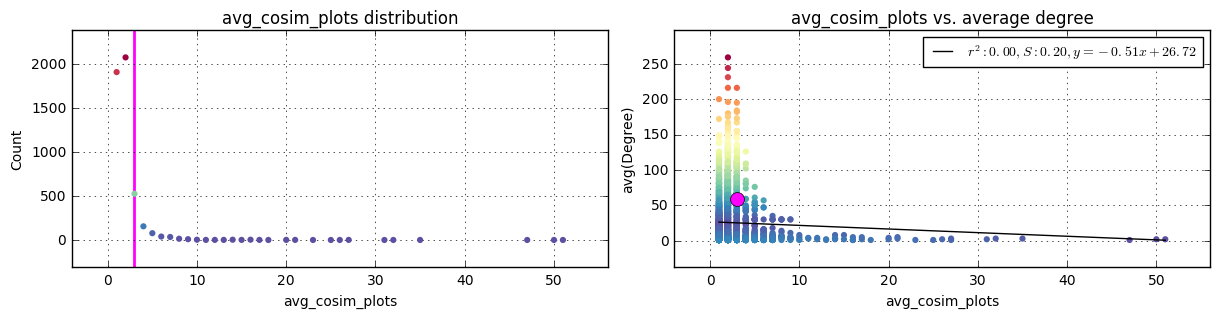

In [56]:
net.plot_attr_dist(MP, ['avg_cosim_plots'], plt.cm.Spectral_r, root=root_movie)

As assumed, the more general the terms are, the more documents fall under category "similar", that's what we see by looking at the average similarity distribution. Still a very little amount of nodes are similar. 

In [57]:
net.assortativity(MP, {'avg_cosim_plots': 'numeric'})


      Type        Attribute     Coef.  Time (sec)
0  numeric  avg_cosim_plots  0.279573    0.748661
1   degree                   0.228427    1.580856



The assortativity towards average similarity based on plot keywords is 2x lower than for those based on keywords, although the distributions are more than similar, it means, the IMDB keywords are really better than plots. We could have also generated some numbers according to power law and discovered how the assortativity would behave to exclude the hypothesis that power law distribution of attributes increases the assortativity without considering a real rule how the nodes attach to each other. But those two examples (keywords and plot keywords) just deliver a proof that one measure is simply better than the other.

In [58]:
net.modularity(MP, ['avg_cosim_plots'])


         Attribute  Communities         M  Time (sec)
0  avg_cosim_plots           30  0.032364    0.826951



The measure is a bad partition of the graph. To illustrate that plot-similarity is more diffuse than keywords-similarity, let us plot a random network area and search for the communities (or at least some distinguishable sections of the graph having the same color).


     N    L  Components  Larg. component         C         p  k_min  k_max  \
0  119  741           1              119  0.627448  0.105541      1    118   

   k_median     k_mean  Time (sec)  
0      10.0  12.453782    0.027676  

Attribute values: 1, 2, 3, 4, 5, -1


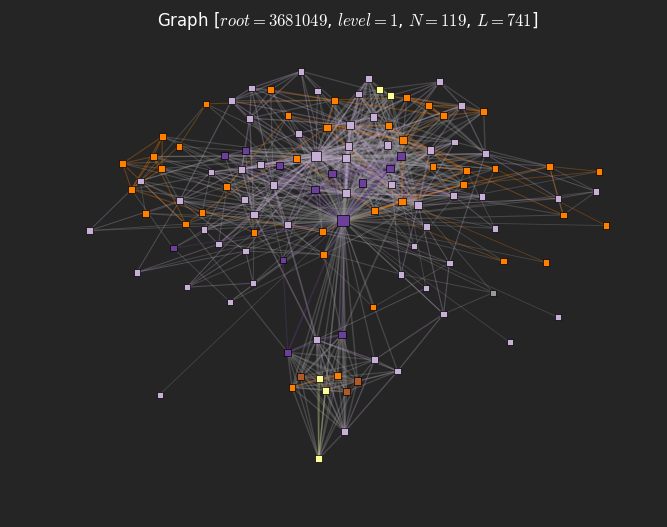

In [94]:
net.draw_graph_attr(
    MP, 
    'avg_cosim_plots', 
    plt.cm.Paired,
    depth=1
)

No zoned sections were found. Low similarities connect both to low and high similarities, and vice versa.

### Similarity vs other attributes

As other attributes, the similarities can be compared using plots. We will use only those attributes which have an absolute zero on the values scale.

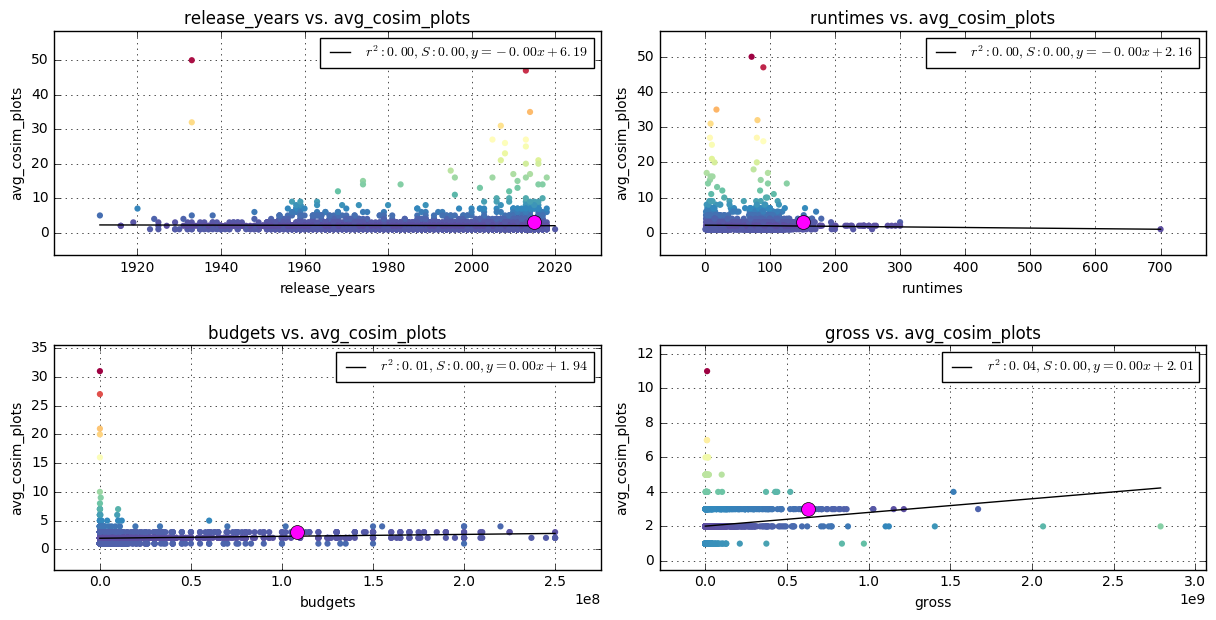

In [60]:
net.plot_attr_vs_attr(
    MP, 
    [
        ('avg_cosim_plots', 'release_years'),
        ('avg_cosim_plots', 'runtimes'),
        ('avg_cosim_plots', 'budgets'),
        ('avg_cosim_plots', 'gross')
    ],
    plt.cm.Spectral_r, 
    root=root_movie
)

There is no single attribute correlated with average similarity. See analysis of keywords for explanation.

## Keywords vs plots

What might be really interesting is comparing both similarity measures together. We expect both keywords and plots to be somewhat correlated, as plots describe the same contents but in a different, more readable for humans, way. We use a scatterplot to plot similarity on keywords versus similarity on plot keywords below.

In [105]:
import csv
with open('data/kwdsvsplots.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Similarity (keywords)', 'Similarity (plots)'])
    common_pairs = list(set.intersection(set(edge_cosim_MK), set(edge_cosim_MP)))
    for e in common_pairs:
        writer.writerow([round(edge_cosim_MK[e], 3), round(edge_cosim_MP[e], 3)])

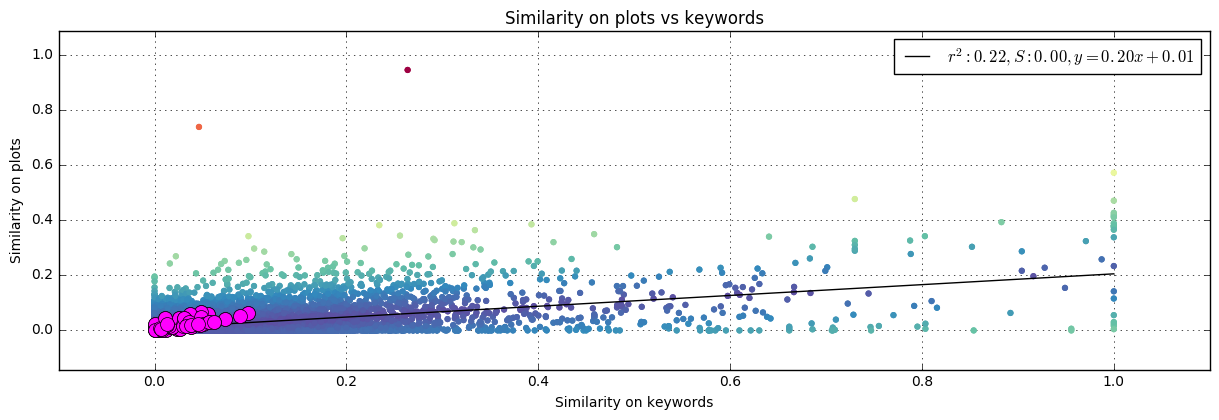

In [61]:
feat.plot_pairs_cosim(edge_cosim_MK, edge_cosim_MP, plt.cm.Spectral_r, root=root_movie)

The $r^2=0.20$ is a very moderate result, but better than 0. We also discover only 2 based-on-plots-similarities higher than 0.6, because plots contain more "noisy words" than keywords, thus the probability of two documents to share all of them is very, very low. The tf-idf algorithm doesn't filter out those "noisy words", as not all plots contain them, and hence many tf-idf values are low but not zero. That's why the most amount of points are not centered on the plot, but lay on the bottom.

## User reviews

In the last part of the text analysis we are going to discover the large movie review dataset, which consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. We will use the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1).

In [62]:
import codecs
filename = './data/labMIT-1.0.txt'
metrics = {}
with codecs.open(filename, 'r', encoding='utf8') as f:
    lines = f.readlines()
header = lines[0].split('\t')
for line in lines[1:]:
    row = line.split('\t')
    metrics[row[0]] = {header[i]: row[i] for i in range(1, len(row))}

As by working with plots, we will apply the same tokenization technique: extract words, convert them to lowercase, remove stopwords, and select nouns and adjectives only.

In [63]:
reviews = mongo.collect('user_reviews')
reviews_tokenized = { 
    imdb_id: feat.tokenize(' '.join(reviews))
    for imdb_id, reviews in reviews.iteritems()
}

### Sentiments

We will apply sentiment analysis to identify and extract subjective information in user reviews. A set of tokens passed to the following method will be parsed for sentiments if found in LabMT wordlist. 

In [64]:
def sentiment(tokens, metrics):
    tokens_inter = set.intersection(set(tokens), set(metrics.keys()))
    if tokens_inter:
        return np.mean([float(metrics[token]['happiness_average']) for token in tokens_inter])
    return None

In [65]:
sentiments = {
    imdb_id: sentiment(tokens, metrics) 
    for imdb_id, tokens in reviews_tokenized.iteritems()
}
sentiments_sorted = sorted(sentiments.items(), key=lambda x: x[1], reverse=True)
tab = Table()
tab.from_tuples([(
            sentiments_sorted[-1][1], 
            np.mean(sentiments.values()), 
            np.std(sentiments.values()), 
            sentiments_sorted[0][1]
        )], columns=['Min', 'Mean', 'Std', 'Max'])
tab.display()


        Min      Mean       Std      Max
0  4.735625  5.600198  0.151387  6.40125



After all sentiments were assigned, let us descover the distribution of sentiments across user reviews.

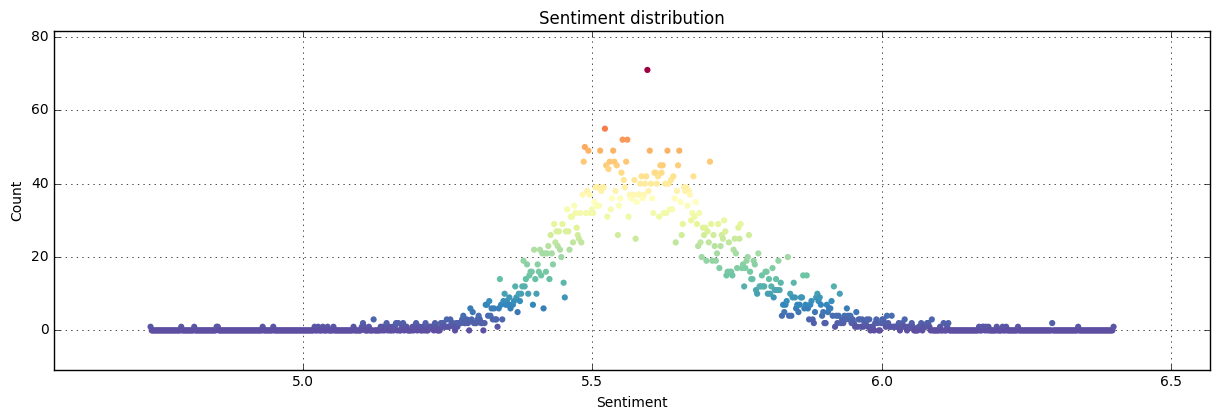

In [66]:
feat.plot_dist(sentiments.values(), plt.cm.Spectral_r, 'Sentiment')

We see sentiments distribution to be similar to the normal distribution, ranging from $min=4.7$ to $max=6.4$, where the mean $\mu=5.6$ and standard deviation $\sigma=0.15$. To illustrate that sentiments were calculated properly, let us pick up the most negative and the most positive review.

In [67]:
reviews[sentiments_sorted[0][0]]

[u'Very obvious nods to "Vertigo", but that shouldn\'t distract from a very good film. This is a film of beauty and comedy. You whirl through the streets of Hong Kong, and catch a very real sense of modern life in that part of the world.<br /><br />If you like Wong Kar Wai then catch this.']

In [68]:
reviews[sentiments_sorted[-1][0]]

[u'As a western, this movie was so dull and tedious. It has none of the charisma of Young Guns nor the adventure of the Good, Bad and Ugly. There were no gunfire duals, in fact hardly any guns fired at all. What little action there was just showed people falling down after a few gun shots fired. No blood no wounds. Willie Nelson looked too old and too tired for his role. He looked nothing like the supposed "menacing and bloodthirsty" Barbarosa. My vote a 1 out of 10.']

But there are also downsides. Below we print the user review classified as the second most positive one, but in fact it is negative.

In [69]:
reviews[sentiments_sorted[1][0]]

[u"I wasn't interested in the story, mainly because I didn't see the point. Sophie Marceau is the only bright sight in the movie."]

This because the LabMT wordlist contains only labeled words, not compounds. In the example above, *interested* was classified as a positive word, while the algorithm couldn't detect the negotiation. In the following, we will compare other attributes to sentiments.

In [70]:
imdbID_map = {
    omdb_file['imdbID']: id
    for id, omdb_files in mongo.collect('omdb_files').iteritems() 
    for omdb_file in omdb_files
}
sentiments_mapped = {imdbID_map[imdb_id]: sentiment for imdb_id, sentiment in sentiments.iteritems() if imdb_id in imdbID_map}

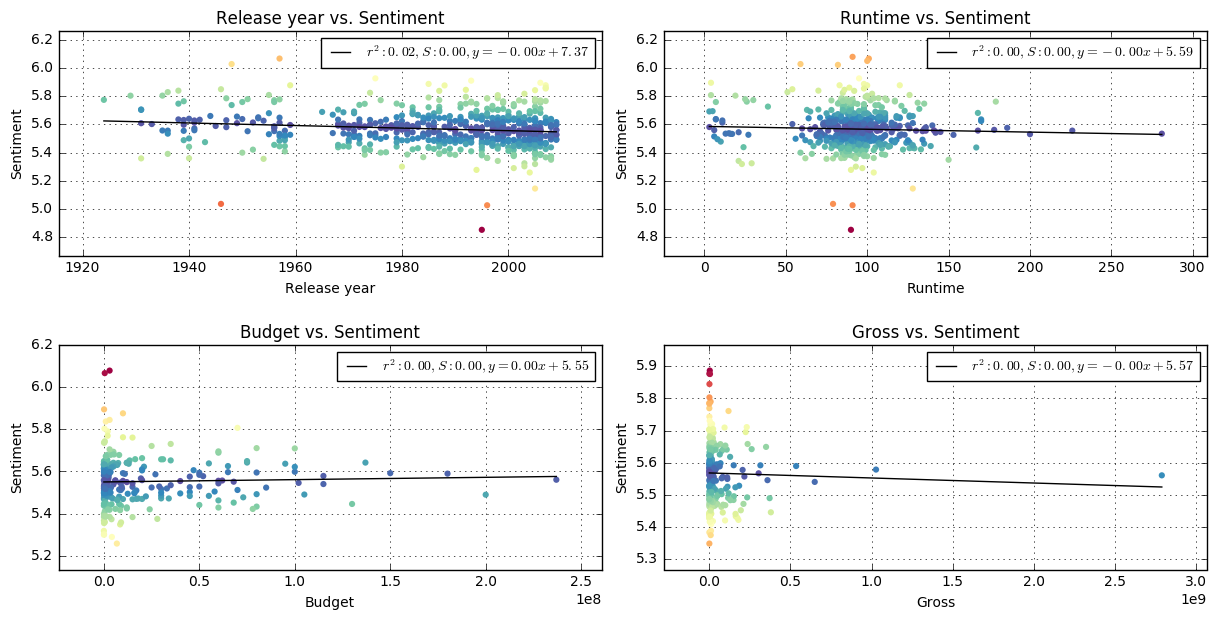

In [71]:
feat.plot_attr_vs_attr([
        ('Release year', {k: v for k, vs in mongo.collect('release_years', filter={'id': {'$in': sentiments_mapped.keys()}}).iteritems() for v in vs}),
        ('Runtime', {k: v for k, vs in mongo.collect('runtimes', filter={'id': {'$in': sentiments_mapped.keys()}}).iteritems() for v in vs}),
        ('Budget', {k: v for k, vs in mongo.collect('budgets', filter={'id': {'$in': sentiments_mapped.keys()}}).iteritems() for v in vs}),
        ('Gross', {k: v for k, vs in mongo.collect('gross', filter={'id': {'$in': sentiments_mapped.keys()}}).iteritems() for v in vs})
    ],
    ('Sentiment', sentiments_mapped),
    plt.cm.Spectral_r,
    root=root_movie
)

We cannot discover any correlation between release year, runtime, budget, and gross, and sentiment. Good and bad films are made every year, and are not depending upon runtime, budget or gross. Reviews are always a matter of taste.

### Most common

Next we will discover terms used in user reviews. We will identify the most common nouns and adjectives, but also their collocations. Collocations are interesting as wordclouds show only words, whereas we would also like to search for compounds (such as bigrams, trigrams, etc).

In [72]:
reviews_tokens = [token for review_tokens in reviews_tokenized.values() for token in review_tokens]

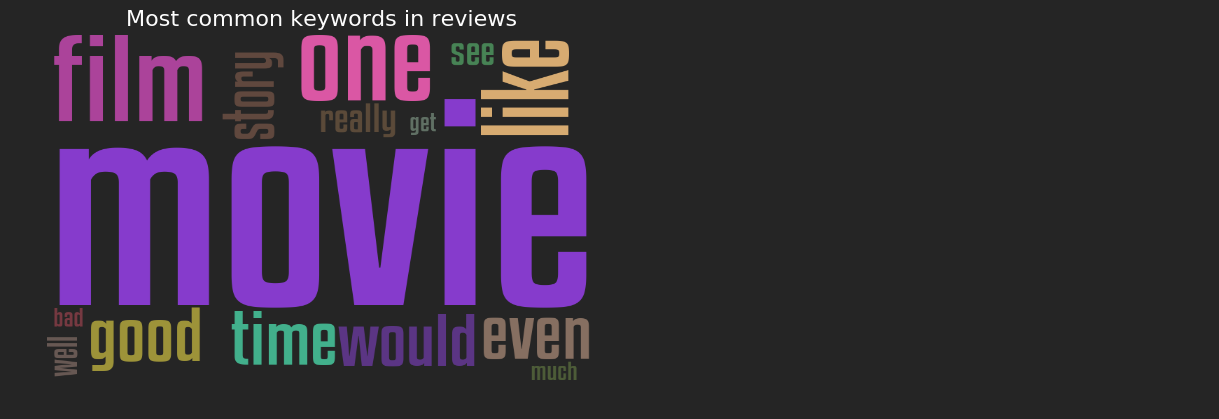

In [73]:
feat.wordclouds({
    'Most common keywords in reviews': Counter(reviews_tokens).most_common()
})

The most common are the words *movie*, *film*, *good*, *time*, ...nothing interesting here. But what about compounds?

In [74]:
def most_common_ngrams(lst, n):
    return Counter(zip(*(lst[i:] for i in range(n)))).most_common()

In [75]:
tab = Table()
tab.from_tuples(most_common_ngrams(reviews_tokens, 2)[:10], columns=['Bigram', 'Score'])
tab.display()


               Bigram  Score
0        (ever, seen)   2669
1  (special, effects)   2455
2      (even, though)   2027
3       (low, budget)   1903
4         (one, best)   1891
5       (looks, like)   1659
6         (new, york)   1604
7         (year, old)   1599
8        (see, movie)   1560
9      (much, better)   1514



Collocations are the most frequent bigrams (a pair of consecutive written words) in text. The first bigram *ever seen* can be used in positive (*the best film I've ever seen*) as well as in negative context (*the worst film...*). Then we see *special effects* are frequently mentioned. *Even though* could mean that the film has positive as well as negative aspects. *Low budget* has mainly positive meaning, like *this film is cool despite its low budget*. And so on. Want to see more? Here are trigrams.

In [76]:
tab = Table()
tab.from_tuples(most_common_ngrams(reviews_tokens, 3)[:10], columns=['Trigram', 'Score'])
tab.display()


                       Trigram  Score
0          (movie, ever, seen)    492
1         (worst, movie, ever)    458
2         (movies, ever, seen)    363
3            (new, york, city)    302
4         (one, worst, movies)    300
5        (worst, movies, ever)    264
6          (movie, ever, made)    241
7           (film, ever, seen)    229
8          (films, ever, seen)    205
9  (texas, chainsaw, massacre)    184



The most of them are extensions to the first bigram *ever seen*. That is how people are more likely express themselves.

### Adjectives

Adjectives are of the most interest for us, as they describe the things. If we filter out the nouns, we finally get rid of the noisy words like *movie*, *film*, and similar. The last interesting thing to discover would be the top 250 positive-written reviews and negative ones.

In [77]:
def adj_only(tokens):
    adj = set([token for token, tag in nltk.pos_tag(set(tokens), tagset='universal') if tag=='ADJ'])
    return [token for token in tokens if token in adj]

In [78]:
top_adj = {
    'Adjectives in top 250 reviews': Counter(adj_only([token for id, _ in sentiments_sorted[:250] for token in reviews_tokenized[id]])).most_common(),
    'Adjectives in bottom 250 reviews': Counter(adj_only([token for id, _ in sentiments_sorted[-250:] for token in reviews_tokenized[id]])).most_common()
}
tab = Table()
tdata = []
for desc, adj in top_adj.iteritems():
    tdata.append((
            desc, 
            sum(zip(*adj)[1]), 
            len(adj), 
            len(adj)/sum(zip(*adj)[1])))
tab.from_tuples(tdata, columns=['Dataset', 'Count', 'Unique', 'Lexical diversity'])
tab.display()


                            Dataset  Count  Unique  Lexical diversity
0  Adjectives in bottom 250 reviews  12833    2476           0.192940
1     Adjectives in top 250 reviews  11549    2255           0.195255



The lexical diversity is almost the same for both lists, as the number of their tokens. Next we want to visualize the lexical difference across those lists using wordclouds.

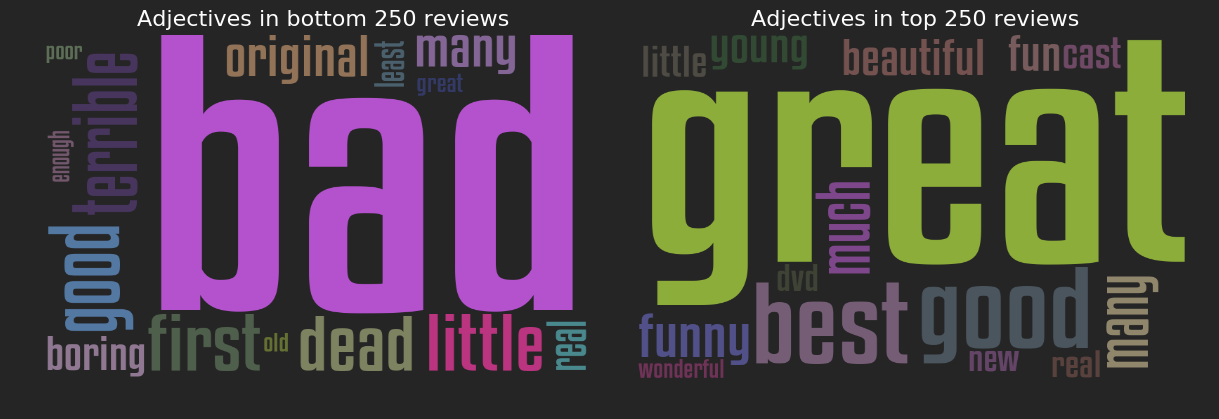

In [79]:
feat.wordclouds(top_adj)

On the left side we see the most common keywords used in the most negative user reviews, and that are *bad*, *terrible*, *dead*, but also *good* (e.g., *a good example for a bad story*). On the right wee see positive terms like *great*, *best*, and *good*. The terms on both sides differ a lot, but they do not mirror feelings of the writer in a best manner. In order to make some assumptions about precision of the classification algorithm you either need to read them all, or perform something more complex, like deep learning.

## Summary

### Keywords

* The most common term is *independent-film*, a feature film that is produced mostly or completely outside of the major film studio system. 
* Films based on a novel enjoy the popularity. 
* More general terms *murder*, *female-nudity*, *sex* and *death* describe what the most films are about: murders and sex.
* Keywords provided by IMDB highly correlate with contents of entire genres. The most common words of science fiction are *alien*, *outer-space*, *monster*, and *robot*. Horror films can be mainly described by terms *murder*, *death*, and *blood*. Terms *murder* and *police* are on the top of crime genre. The term *murder* is also very frequent in dramas. War films commonly show WWII and nazis.
* The most profitable movies are biased towards particular terms.
* *Explosion* is one of the most frequent words for the most expensive movies. The more a production company has money, the more it invests in special effects, and the more explosions it shows. Across top 250 films by gross the most promising are *blockbusters*. *Box-office-hit* keyword (describing a highly-grossing picture) is also the most common in top 250 films by budget. All those keywords are less common for movies with the highest IMDB ratings though, where the *independent-film* and *mockumentary* (parody) top the list.
* The most successful and top-rated films seem to differ a lot, they even mirror opposite trends: almost none of the keyword *independent-film* are present in the keywords set of the most expensive and profitable movies. On the other side, none of the term *box-office-hit* are in top-rated films. The same observation we do wenn we look at word *love*. Quite a lot of top-rated movies are about love, but only a bunch of most successful films are (which are mainly blockbusters with breathtaking explosions), that is, the top-rated films interact with feelings of watchers and trigger sympathy.
* There is no single attribute correlated with similarity. Willing to act in movies of similar content depends on a dicision of an actor rather than on a movie. This decision isn't depending upon year, nor it is depending upon gross, budget and other measures: it is an output of complex psychology of an actor. 
* The most movies ($73\%$) aren't similar regarding keywords, meaning that keywords are maybe to concrete for a similarity measure. But, having seen those keywords anywhere, you will be able to identify the movie right away.
* The actors tend to play in movies described by similar keywords (moderately though).

### Plots

* The plot keywords contain a lot of general information. They depend upon language of a writer and how he expresses himself. On the top is word *life*, which is the most central element of all movies - a human. 
* Movies that show a global picture, focus on big stories, on wars, on everything that touches the whole humanity - they have the term *world* in common. While those movies that focus on individuals mostly use in plots term *life*. That's the wonderful discovery about plots: they include information readable by humans, that is, abstractions and some details, and hence enable a semantic hierarchy. We cannot tell the same about keywords, which tell the story in a very detail.
* If we talk about general information, than plots may be useful to describe the top lists. The 250 most expensive films tend to show a global picture and operate on a world level, they may try to include many scenes in many countries for the money they have. The top rated movies tend to tell some sweet stories and this way get in touch with feelings of audience. Highest-grossing films tend to deliver some new content. 
* Like by keywords, the top-rated films and the most expensive and successful films show opposite trends ragarding plots. Top-rated movies tend to tell stories about (young) individuals and their unique destinies, while the most profitable ones provide new contents (*new*) and show something very global.
* The IMDB keywords are really better than plots in measuring similarity.
* There is no single attribute correlated with plots-similarity.
* Plots and keywords are weakly correlated.

### User reviews

* Sentiments of user reviews follow normal distribution.
* Sentiment analysis produces many errors, e.g., the user review classified as the second most positive is in fact negative. This because the LabMT wordlist contains only labeled words, not compounds, so the algorithm cannot detect a negotiation or sarcasm. 
* We cannot discover any correlation between sentiment and release year, runtime, budget, and gross. Good and bad films are made every year, and are not depending upon runtime, budget or gross. Reviews are always a matter of taste.
* The most common keywords are *movie*, *film*, *good*, and *time*.
* The most trigrams contain bigram *ever seen*; expressions like that indicate that the movie made a big impression on the viewer.
* Sentiments are not precise. Negotiations may provide some problems when classifying data. Extending the wordlist by compounds may be a solution, whereby one very difficult to implement.